### Importing all important libraries

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Lambda,Layer
import matplotlib.pyplot as plt 
from keras.models import save_model,load_model

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS=3
EPOCHS=50

### Create Preprocessing of image dataset form given Directrory


In [3]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "DataSet",
    shuffle=True, #Shuffle avoids the overfitting of model
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 10000 files belonging to 10 classes.


#### Displaying the type of Disease

In [4]:
class_name = dataset.class_names
class_name

['Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Tomato___Target_Spot',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato___Tomato_mosaic_virus',
 'Tomato___healthy']

In [5]:
len(dataset)

313

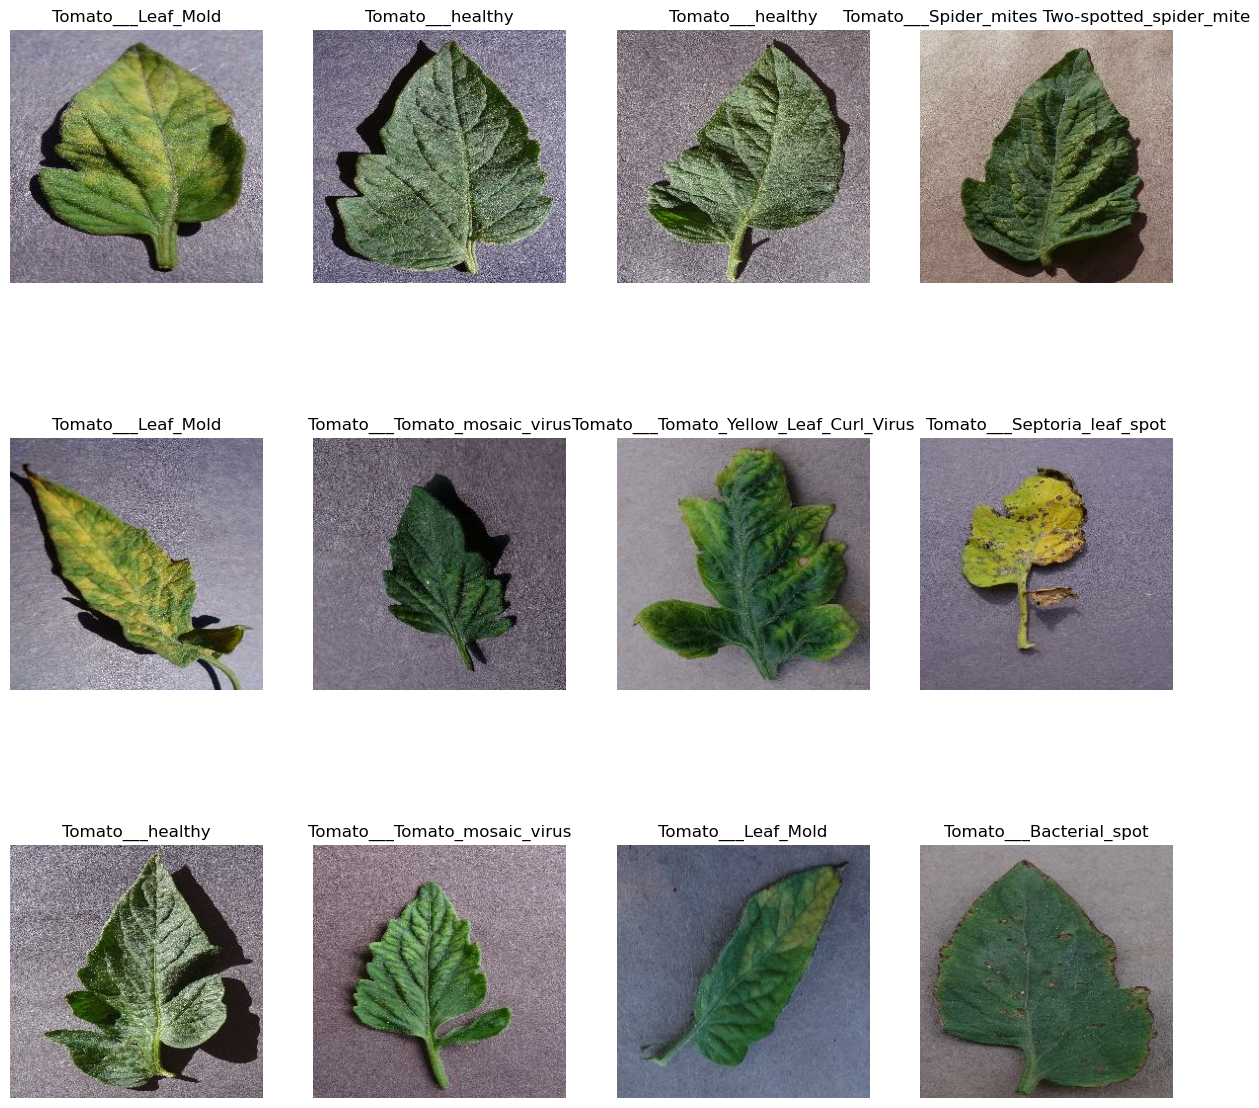

In [6]:
plt.figure(figsize=(15,15))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_name[label_batch[i]])
        plt.axis("off")


In [7]:
len(dataset)

313

In [8]:
train_size =0.8
len(dataset)*train_size

250.4

In [9]:
train_ds=dataset.take(250)
len(train_ds)

250

In [10]:
test_ds = dataset.skip(250)
len(test_ds)

63

In [11]:
val_size = 0.1
len(dataset)*val_size

31.3

In [12]:
val_ds = test_ds.skip(31)
len(val_ds)

32

In [13]:
test_ds = test_ds.skip(32)
len(test_ds)

31

#### This is a function to partition a given dataset into three parts train, validation, test set, based on the split ratios (8:1:1).

In [14]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [15]:
train_ds,val_ds,test_ds = get_dataset_partitions_tf(dataset)

In [16]:
len(train_ds)

250

In [17]:
len(val_ds)

31

In [18]:
len(test_ds)

32

In [19]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

Resizing : This is typically done to ensure that all images have the same size
Rescaling : Rescales the pixel values of the resized images to a range of [0, 1]. This is typically done to normalize the pixel values and ensure that they are within a reasonable range for the model to work correctly

In [20]:
resize_and_rescale = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  tf.keras.layers.experimental.preprocessing.Rescaling(1.0/255),
])

#### Data augmentation is a technique of artificially increasing the training set by creating modified copies of a dataset using existing data.


In [21]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

In [22]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

CNN Model

In [23]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE,CHANNELS)
n_classes = 10

model = tf.keras.models.Sequential([
    resize_and_rescale,
    tf.keras.layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [24]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [25]:
model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
)

In [26]:
history = model.fit(train_ds,validation_data=val_ds,batch_size=BATCH_SIZE, epochs=50)

Epoch 1/50
250/250 [==============================] - 184s 584ms/step - loss: 1.8140 - accuracy: 0.3263 - val_loss: 1.2947 - val_accuracy: 0.5454
Epoch 2/50
250/250 [==============================] - 52s 207ms/step - loss: 1.0627 - accuracy: 0.6306 - val_loss: 0.8657 - val_accuracy: 0.6895
Epoch 3/50
250/250 [==============================] - 80s 322ms/step - loss: 0.8310 - accuracy: 0.7087 - val_loss: 0.7553 - val_accuracy: 0.7278
Epoch 4/50
250/250 [==============================] - 81s 322ms/step - loss: 0.6833 - accuracy: 0.7605 - val_loss: 0.6621 - val_accuracy: 0.7631
Epoch 5/50
250/250 [==============================] - 44s 176ms/step - loss: 0.5635 - accuracy: 0.8065 - val_loss: 0.5323 - val_accuracy: 0.8125
Epoch 6/50
250/250 [==============================] - 164s 657ms/step - loss: 0.4953 - accuracy: 0.8317 - val_loss: 0.5098 - val_accuracy: 0.8216
Epoch 7/50
250/250 [==============================] - 51s 202ms/step - loss: 0.4015 - accuracy: 0.8608 - val_loss: 0.3186 - val_

In [27]:
scores = model.evaluate(test_ds)

32/32 [==============================] - 28s 59ms/step - loss: 0.1286 - accuracy: 0.9727


In [28]:
scores

[0.12864428758621216, 0.97265625]

In [31]:
history

In [32]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 250}

In [33]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [34]:
type(history.history['loss'])

list

In [35]:
len(history.history['loss'])

50

In [36]:
history.history['loss'][:5]

[1.8139938116073608,
 1.0626633167266846,
 0.8309766054153442,
 0.6833170056343079,
 0.5634963512420654]

In [37]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

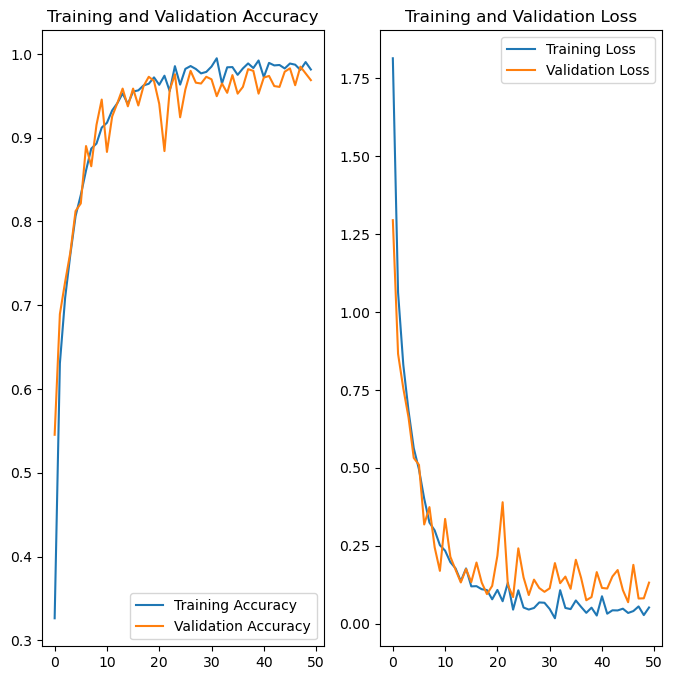

In [38]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Tomato___Leaf_Mold
1/1 [==============================] - 0s 79ms/step
predicted label: Tomato___Leaf_Mold


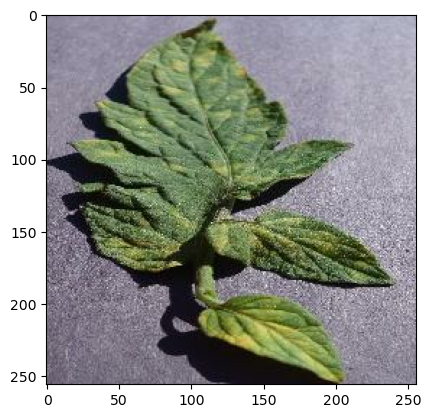

In [39]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_name[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_name[np.argmax(batch_prediction[0])])

In [40]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_name[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 53ms/step


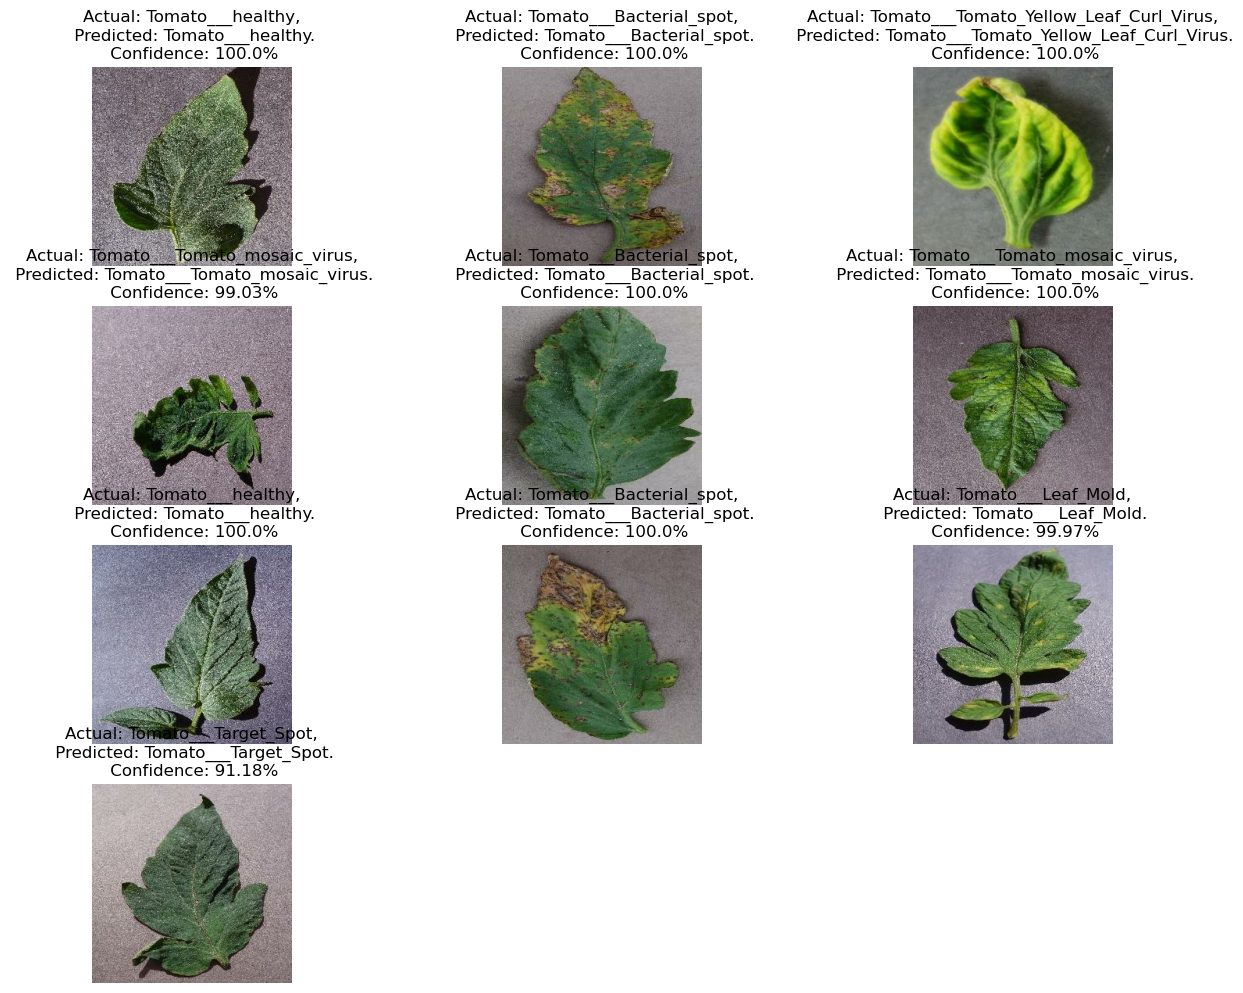

In [42]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(10):
        ax = plt.subplot(5, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_name[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [44]:
import os
model_version=max([int(i) for i in os.listdir("../saved_models") + [0]])+1
model.save(f"../saved_models/{model_version}")

INFO:tensorflow:Assets written to: ../model/6\assets


INFO:tensorflow:Assets written to: ../model/6\assets


In [45]:
model.save('m1.h5')

In [49]:
new_model = load_model("m1.h5")

first image to predict
actual label: Tomato___Septoria_leaf_spot
1/1 [==============================] - 0s 194ms/step
predicted label: Tomato___Septoria_leaf_spot


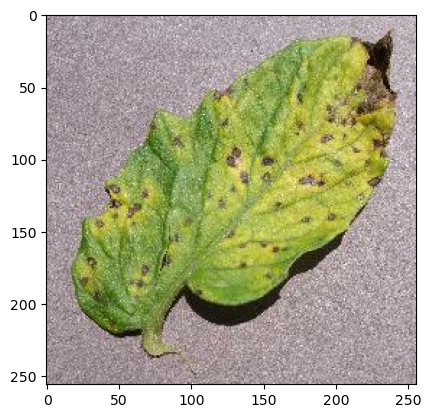

In [50]:
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_name[first_label])
    
    batch_prediction = new_model.predict(images_batch)
    print("predicted label:",class_name[np.argmax(batch_prediction[0])])